In [19]:
import json
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_capability(0))

NVIDIA GeForce RTX 3090
(8, 6)


In [38]:

def read_until_batch_id(file_path, search_string="{\"batch_id\":", chunk_size=1024):
    buffer = ""
    next_string_distances = []
    current_position = 0  # 파일 내 현재 위치를 추적
    last_position = None
    
    with open(file_path, 'r', encoding='utf-8') as file:
        while True:
            chunk = file.read(chunk_size)
            if not chunk:
                break
            
            buffer += chunk

            while True:
                pos = buffer.find(search_string)
                if pos != -1:
                    found_position = current_position + pos
                    # found_positions.append(found_position)

                    if last_position is not None:
                        next_string_distances.append(found_position - last_position)

                    last_position = found_position
                    
                    buffer = buffer[pos + len(search_string):]
                    
                    current_position += pos + len(search_string)
                else:
                    # current_position += len(buffer)
                    # buffer = buffer[max(0, len(buffer) - chunk_size):]
                    break

    return next_string_distances

In [28]:
def add_dicts(dict1, dict2):
    result = {}
    
    for key in dict1:
        if isinstance(dict1[key], dict):
            # 만약 항목이 또 다른 dict라면, 재귀적으로 처리
            result[key] = add_dicts(dict1[key], dict2[key])
        else:
            # float 값이면 더하기
            result[key] = dict1[key] + dict2[key]
    
    return result

def initialize_dict_with_zeros(d):
    initialized_dict = {}
    
    for key, value in d.items():
        if isinstance(value, dict):
            # 내부 dict일 경우, 재귀적으로 처리
            initialized_dict[key] = initialize_dict_with_zeros(value)
        else:
            # float 값일 경우, 0으로 초기화
            initialized_dict[key] = 0.0
    
    return initialized_dict

def initialize_empty_dict(structure):
    if isinstance(structure, dict):
        return {key: initialize_empty_dict(value) for key, value in structure.items()}
    else:
        return []

def aggregate_jsons(json_list):
    aggregated_dict = initialize_empty_dict(json_list[0])

    for json_data in json_list:
        add_values_to_dict(aggregated_dict, json_data)
    
    return aggregated_dict

def add_values_to_dict(aggregated_dict, json_data):
    for key, value in json_data.items():
        if isinstance(value, dict):
            add_values_to_dict(aggregated_dict[key], value)
        else:
            aggregated_dict[key].append(value)
            
def make_steps(filename):
    search_string = "{\"batch_id\":"
    next_string_distances = read_until_batch_id(filename, search_string, 1024)

    step_time_data_list = []
    with open(filename, 'r', encoding='utf-8') as file:
        read_start_point = 0
        for i, idx in enumerate(next_string_distances):
            file.seek(read_start_point)
            data = file.read(idx - 2)
            json_data = json.loads(data)
            step_time_data_list.append(json_data)
            read_start_point = read_start_point + next_string_distances[i]

    print(len(step_time_data_list))

    for step in step_time_data_list:
        summary = initialize_dict_with_zeros(step_time_data_list[1]["layers"][0])
        step["summary"] = summary
        # print(i)
        for layer in step["layers"]:
            step["summary"] = add_dicts(step["summary"], layer)
            
    prefill_steps = [step for step in step_time_data_list if (step["arithType"]=="prefill" or step["arithType"]=="")]
    decode_steps = [step for step in step_time_data_list if (step["arithType"]=="decode" or step["arithType"]=="")]
    print(f"Number of steps with no requests ")
    print(len([step for step in step_time_data_list if step["arithType"]==""]))
    
    return step_time_data_list, prefill_steps, decode_steps

## Check time line

In [14]:
def plot_request_and_adapter_numbers(step_list):
    step = range(len(step_list))
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    
    plt.plot(step, request_numbers, label='Request numbers(Batch size)')
    plt.plot(step, adapter_numbers, label='Adapter numbers')
    
    plt.title("Adapter Numbers")
    plt.xlabel("Step")
    plt.ylabel("Number")
    
    plt.legend()
    
    plt.show()

In [13]:
def plot_request_and_adapter_numbers(step_list):
    step = range(len(step_list))
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    
    plt.plot(step, request_numbers, label='Request numbers(Batch size)')
    plt.plot(step, adapter_numbers, label='Adapter numbers')
    
    plt.title("Adapter Numbers")
    plt.xlabel("Step")
    plt.ylabel("Number")
    
    plt.legend()
    
    plt.show()
    
def plot_batch_and_summaries_by_step(step_list):
    step = range(len(step_list))
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    
    summarys = [step["summary"] for step in step_list]
    
    summary_dict = aggregate_jsons(summarys)
    
    fig, ax1 = plt.subplots()
    ax1.plot(step, request_numbers, color='purple', label='Request numbers(Batch size)')
    #ax1.plot(step, adapter_numbers, color='brown', label='Adapter numbers')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Numbers')
    ax1.tick_params(axis='y')
    
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    #ax2.plot(step, summary_dict["total_ffn_time"], label='total_ffn_time')
    #ax2.plot(step, summary_dict["total_attention_time"], label='total_attention_time')
    #ax2.plot(step, summary_dict["atten_norm"], label='atten_norm')
    #ax2.plot(step, summary_dict["precache"], label='precache')
    ax2.plot(step, summary_dict["get_qkv"]["total_time"], label='get_qkv')
    #ax2.plot(step, summary_dict["postcache"], label='postcache')
    #ax2.plot(step, summary_dict["atten_calc"], label='atten_calc')
    #ax2.plot(step, summary_dict["get_o"]["total_time"], label='get_o')
    
    ax2.set_ylabel('Func times (ms)')
    ax2.tick_params(axis='y')
    #ax2.set_ylim(0, 400)
    ax2.legend(loc='upper right')
    
    ax1.legend(loc='center left', bbox_to_anchor=(1.15, 0.8))
    ax2.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))
    
    plt.title('Relationship of Batch size and time')
    
    plt.show()

def plot_batch_and_summaries_by_time(step_list):
    time = [step["run_time"] - step_list[0]["run_time"] for step in step_list]
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    
    summarys = [step["summary"] for step in step_list]
    
    summary_dict = aggregate_jsons(summarys)
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, request_numbers, color='purple', label='Request numbers(Batch size)')
    #ax1.plot(time, adapter_numbers, color='brown', label='Adapter numbers')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Numbers')
    ax1.tick_params(axis='y')
    
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    #ax2.plot(time, summary_dict["total_ffn_time"], label='total_ffn_time')
    #ax2.plot(time, summary_dict["total_attention_time"], label='total_attention_time')
    #ax2.plot(time, summary_dict["atten_norm"], label='atten_norm')
    #ax2.plot(time, summary_dict["precache"], label='precache')
    ax2.plot(time, summary_dict["get_qkv"]["total_time"], label='get_qkv')
    #ax2.plot(time, summary_dict["postcache"], label='postcache')
    #ax2.plot(time, summary_dict["atten_calc"], label='atten_calc')
    #ax2.plot(time, summary_dict["get_o"]["total_time"], label='get_o')
    
    ax2.set_ylabel('Func times (ms)')
    ax2.tick_params(axis='y')
    #ax2.set_ylim(0, 400)
    ax2.legend(loc='upper right')
    
    ax1.legend(loc='center left', bbox_to_anchor=(1.15, 0.8))
    ax2.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))
    
    plt.title('Relationship of Batch size and time')
    
    plt.show()
    
def plot_histogram(x, y, x_value):
    sorted_data = sorted(zip(x, y), key=lambda pair: pair[0])
    x, y = zip(*sorted_data)
    
    grouped_data = defaultdict(list)
    for xi, yi in zip(x, y):
        grouped_data[xi].append(yi)

    plt.hist(grouped_data[x_value], bins=5, edgecolor='black')
    plt.xlabel('X Axis')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()

In [ ]:
some_step_time_data_list, some_prefill_steps, some_decode_steps = make_steps("somelog.txt")

In [ ]:
plot_batch_and_summaries_by_time(some_prefill_steps)
plot_batch_and_summaries_by_time(some_decode_steps)

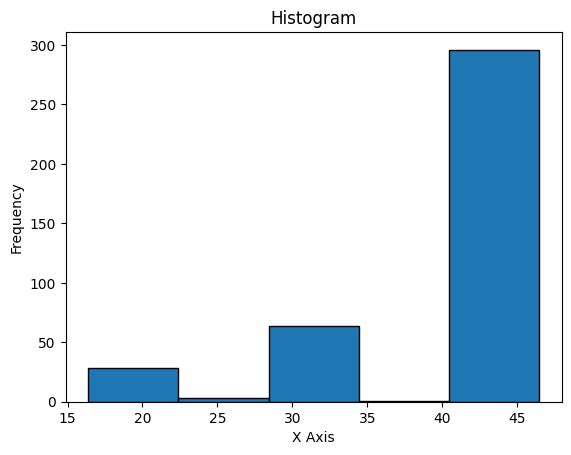

In [64]:
request_numbers = [step["request_num"] for step in some_prefill_steps]
adapter_numbers = [step["adapter_num"] for step in some_prefill_steps]
summarys = [step["summary"] for step in some_prefill_steps]
summary_dict = aggregate_jsons(summarys)
plot_histogram(request_numbers, summary_dict["total_attention_time"], 4)

In [92]:
## Not used anymore

def create_subplot_data_line(x, y):
    sorted_data = sorted(zip(x, y), key=lambda pair: pair[0])
    x, y = zip(*sorted_data)
    
    grouped_data = defaultdict(list)
    for xi, yi in zip(x, y):
        grouped_data[xi].append(yi)
    
    x_vals = []
    y_lows = []
    y_highs = []
    y_average = []
    
    for xi in sorted(grouped_data):
        y_list = grouped_data[xi]
        x_vals.append(xi)
        y_lows.append(min(y_list))
        y_highs.append(max(y_list))
        y_average.append(sum(y_list) / len(y_list))
    
    y_medians = [(low + high) / 2 for low, high in zip(y_lows, y_highs)]

    return x_vals, y_lows, y_highs, y_average, y_medians
  

def plot_batch_and_execution_time_relationship_line(step_list): 
    width = 3
    height = 2
    _, axs = plt.subplots(height, width, figsize=(12, 8))
    
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    summarys = [step["summary"] for step in step_list]
    summary_dict = aggregate_jsons(summarys)

    x_items = [request_numbers, adapter_numbers]
    y_items = [summary_dict["total_attention_time"], summary_dict["get_qkv"]["total_time"], summary_dict["get_o"]["total_time"]]
    y_titles = ["total_attention_time", "get_qkv", "get_o"]
    
    for i in range(height):
        for j in range(width):
            x_vals, y_lows, y_highs, y_average, y_medians = create_subplot_data_line(x_items[i], y_items[j])
            
            correlation_matrix = np.corrcoef(x_items[i], y_items[j])
            correlation = correlation_matrix[0, 1]
            
            for x, y_low, y_high in zip(x_vals, y_lows, y_highs):
                axs[i,j].plot([x, x], [y_low, y_high], color='blue') 
                axs[i,j].plot([x - 0.01, x + 0.01], [y_low, y_low], color='blue')
                axs[i,j].plot([x - 0.01, x + 0.01], [y_high, y_high], color='blue')
            
            axs[i,j].plot(x_vals, y_average, marker='o', linestyle='-', color='red', label='Average Line')
            axs[i,j].set_title(f"{y_titles[j]}")
            axs[i,j].text(0.5, -0.1, f"correlation : {correlation:0.2f}", ha='center', va='center', transform=axs[i, j].transAxes)
    
    plt.tight_layout()
    plt.show()

## Latency by function

In [12]:
def create_sub_plot_data_scatter(x, y):
    x = np.array(x)
    y = np.array(y)
    x_grouped = []
    y_grouped = []
    sizes = []
    
    for unique_x in np.unique(x):
        y_values = y[x == unique_x]
        y_rounded = np.round(y_values, 3)
        y_counts = Counter(y_rounded) 

        total_count = 0
        for y_val, count in y_counts.items():
            x_grouped.append(unique_x)
            y_grouped.append(y_val)
            total_count = total_count + count

        for y_val, count in y_counts.items():
            sizes.append(10 * count / total_count)

    return x_grouped, y_grouped, sizes

def plot_tokenlen_and_execution_time_relationship(step_list): 
    width = 3
    height = 3
    _, axs = plt.subplots(height, width, figsize=(12, 8))
    
    input_token_lens = [step["total_token_num"] for step in step_list]
    ranks = [step["ranks"] for step in step_list]
    #max_rank = [step["max_rank"] for step in step_list]
    
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    #token_len_rank = [token_len * rank for token_len, rank in zip(request_numbers, max_rank)]
    
    summarys = [step["summary"] for step in step_list]
    summary_dict = aggregate_jsons(summarys)

    y_items = [
        summary_dict["total_attention_time"], summary_dict["get_qkv"]["total_time"], summary_dict["get_o"]["total_time"],
        summary_dict["get_qkv"]["detail"]["q_base"], summary_dict["get_qkv"]["detail"]["q_base"], summary_dict["get_qkv"]["detail"]["q_rotary_emb"],
        summary_dict["get_qkv"]["detail"]["k_base"], summary_dict["get_qkv"]["detail"]["k_base"], summary_dict["get_qkv"]["detail"]["k_rotary_emb"],
    ] 
    
    x_title = "total_prompt_size"
    y_titles = [
        "total_attention_time", "get_qkv", "get_o",
        "q_base", "q_lora", "q_rotary_emb",
        "k_base", "k_lora", "k_rotary_emb",
    ]
    
    for i in range(height):
        for j in range(width):

            # if i * height + j >= len(y_items):
            #     break
            
            correlation_matrix = np.corrcoef(input_token_lens, y_items[i * height + j])
            correlation = correlation_matrix[0, 1]

            x, y, size = create_sub_plot_data_scatter(input_token_lens, y_items[i * height + j])
            
            axs[i,j].scatter(x, y, s=size, edgecolors='black', color='blue', alpha=0.6)
            axs[i,j].set_title(f"{y_titles[i * height + j]}")
            axs[i,j].text(0.5, -0.2, f"{correlation:0.2f}", ha='center', va='center', transform=axs[i, j].transAxes)
            axs[i,j].set_xlabel(f"{x_title}", labelpad=10, loc='right')
            axs[i,j].set_ylabel('Latency (ms)')
    plt.tight_layout()
    plt.show()

In [10]:
step_time_data_list_real_code, prefill_steps_real_code, decode_steps_real_code = make_steps("real_Code.txt")

49572
Number of steps with no requests 
5


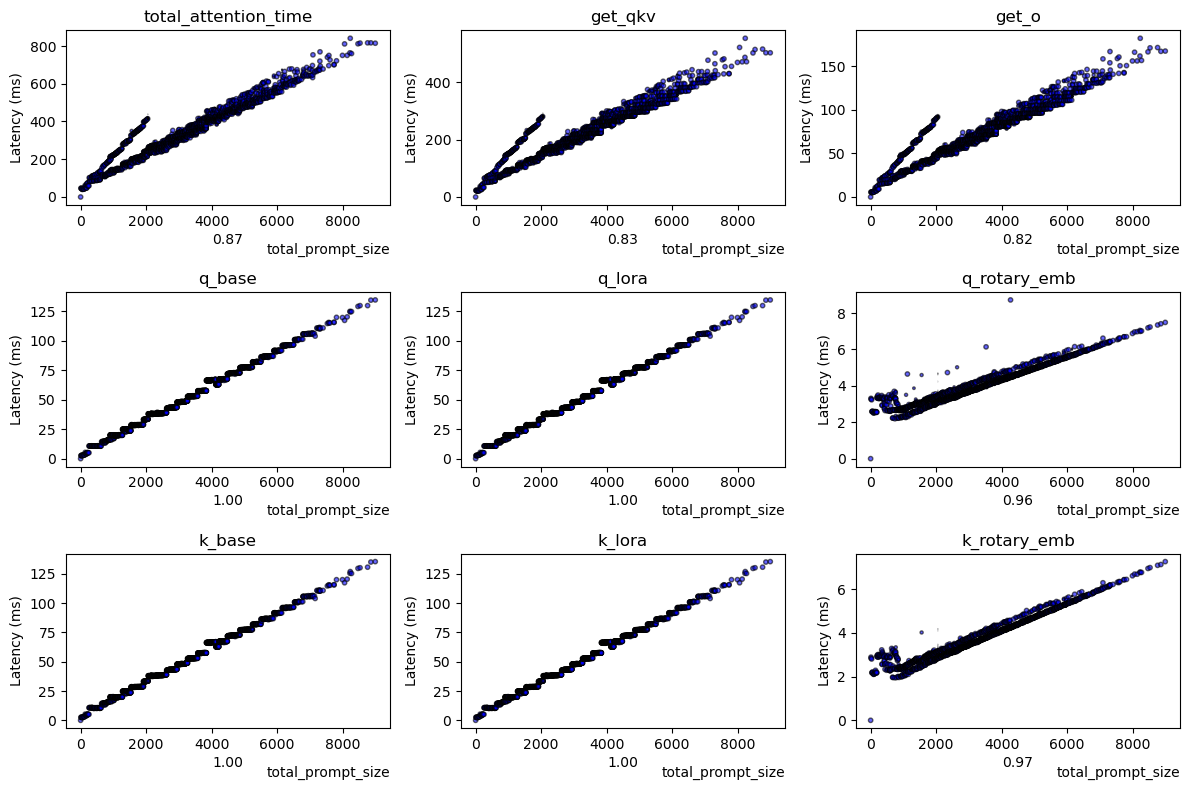

In [13]:
plot_tokenlen_and_execution_time_relationship(prefill_steps_real_code)

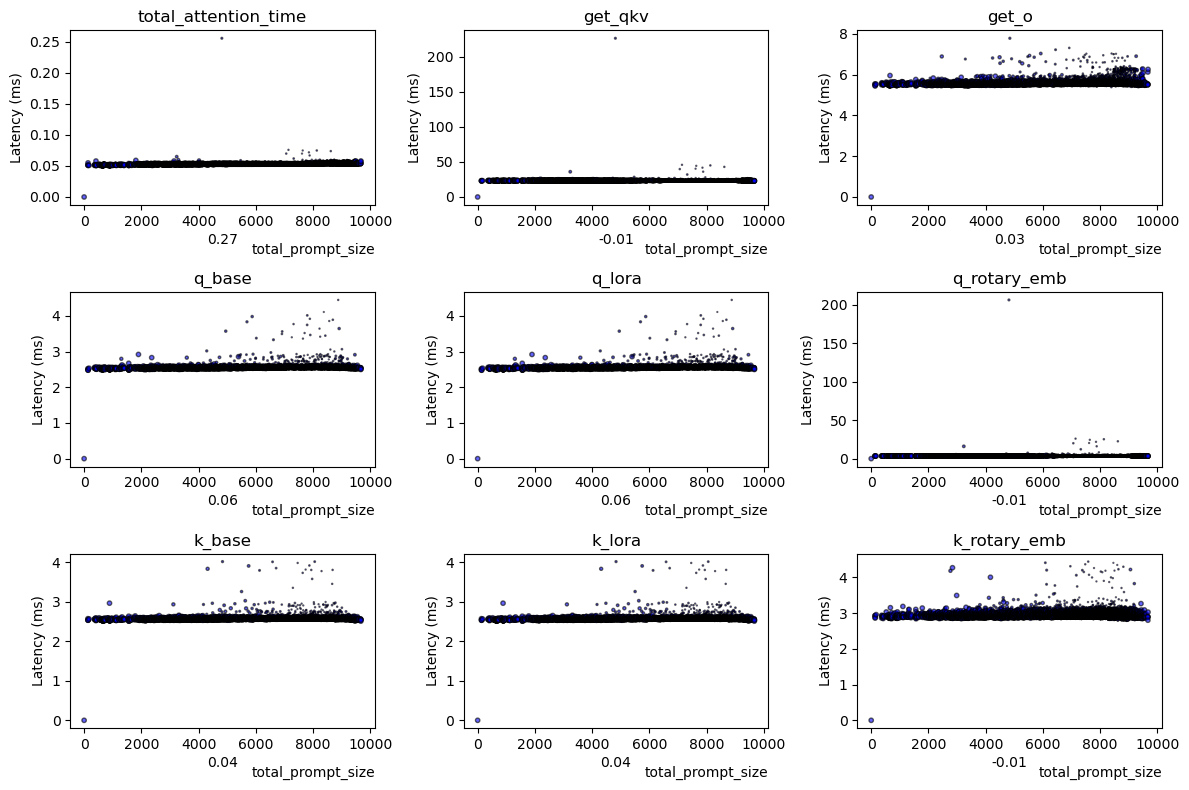

In [14]:
plot_tokenlen_and_execution_time_relationship(decode_steps_real_code)

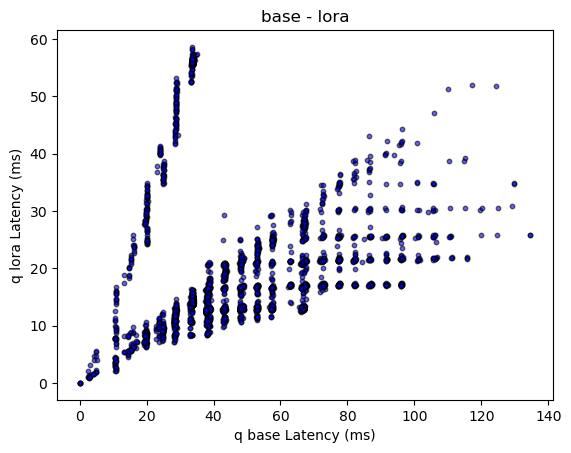

In [15]:
def plot_base_and_lora_relationship(step_list): 
    summarys = [step["summary"] for step in step_list]
    summary_dict = aggregate_jsons(summarys)

    x = summary_dict["get_qkv"]["detail"]["q_base"]
    y = summary_dict["get_qkv"]["detail"]["q_lora"]
    x_title = "q_base"
    y_title = "q_lora"
         
    correlation_matrix = np.corrcoef(x, y)
    correlation = correlation_matrix[0, 1]

    plt.scatter(x, y, s=10, edgecolors='black', color='blue', alpha=0.6)
    plt.title('base - lora')
    plt.xlabel('q base Latency (ms)')
    plt.ylabel('q lora Latency (ms)')
    plt.show()
    
plot_base_and_lora_relationship(prefill_steps_real_code)

In [17]:
_, prefill_steps_rank_8, decode_steps_rank_8 = make_steps("batchsize_1_token_1200_sync.txt")

45
Number of steps with no requests 
1


### Latency by Rank

In [23]:
_, prefill_steps_punica_rank_8,  decode_steps_punica_rank_8  = make_steps("rankTest/rank_8_only_custom.txt")
_, prefill_steps_punica_rank_16, decode_steps_punica_rank_16 = make_steps("rankTest/rank_16_only_custom.txt")
_, prefill_steps_punica_rank_32, decode_steps_punica_rank_32 = make_steps("rankTest/rank_32_only_custom.txt")
_, prefill_steps_punica_rank_64, decode_steps_punica_rank_64 = make_steps("rankTest/rank_64_only_custom.txt")

7612
Number of steps with no requests 
1
8201
Number of steps with no requests 
3
8057
Number of steps with no requests 
3
8340
Number of steps with no requests 
1


In [24]:
def create_sub_plot_data_scatter(x, y):
    x = np.array(x)
    y = np.array(y)
    x_grouped = []
    y_grouped = []
    sizes = []
    
    for unique_x in np.unique(x):
        y_values = y[x == unique_x]
        y_rounded = np.round(y_values, 7)
        y_counts = Counter(y_rounded) 
    

        total_count = 0
        for y_val, count in y_counts.items():           
            x_grouped.append(unique_x)
            y_grouped.append(y_val)
            total_count = total_count + count

        for y_val, count in y_counts.items():
            sizes.append(10 * count / total_count)

    return x_grouped, y_grouped, sizes

def create_xy(step_list):
    input_token_lens = [step["total_token_num"] for step in step_list]
    ranks = [step["ranks"] for step in step_list]
    max_rank = [step["max_rank"] for step in step_list]
    
    request_numbers = [step["request_num"] for step in step_list]
    adapter_numbers = [step["adapter_num"] for step in step_list]
    token_len_rank = [token_len * rank for token_len, rank in zip(request_numbers, max_rank)]
    
    summarys = [step["summary"] for step in step_list]
    summary_dict = aggregate_jsons(summarys)

    return input_token_lens, summary_dict["get_qkv"]["detail"]["q_lora"]

def plot_tokenlen_rank_and_execution_time_relationship(step_list_rank_8, step_list_rank_16, step_list_rank_32, step_list_rank_64):
    
    x1, y1 = create_xy(step_list_rank_8)
    #y1 = [0 if val > 1000 else val for val in y1]
    x1, y1, size1 = create_sub_plot_data_scatter(x1, y1)
    
    
    x2, y2 = create_xy(step_list_rank_16)
    #y2 = [0 if val > 1000 else val for val in y2]
    x2, y2, size2 = create_sub_plot_data_scatter(x2, y2)
    
    x3, y3 = create_xy(step_list_rank_32)
    #y3 = [0 if val > 1000 else val for val in y3]
    x3, y3, size3 = create_sub_plot_data_scatter(x3, y3)
    
    x4, y4 = create_xy(step_list_rank_64)
    #y4 = [0 if val > 1000 else val for val in y4]
    x4, y4, size4 = create_sub_plot_data_scatter(x4, y4)
    
    plt.scatter(x1, y1, s=size1, label="rank_8", edgecolors='black', color='blue', alpha=0.2)
    plt.scatter(x2, y2, s=size2, label="rank_16", edgecolors='black', color='green', alpha=0.2)
    plt.scatter(x3, y3, s=size3, label="rank_32", edgecolors='black', color='red', alpha=0.2)
    plt.scatter(x4, y4, s=size4, label="rank_64", edgecolors='black', color='m', alpha=0.2)
    
    plt.title("q_lora")
    plt.xlabel("total_prompt_size", labelpad=10, loc='right')
    plt.ylabel('Latency (ms)')
    plt.legend()
    plt.show()

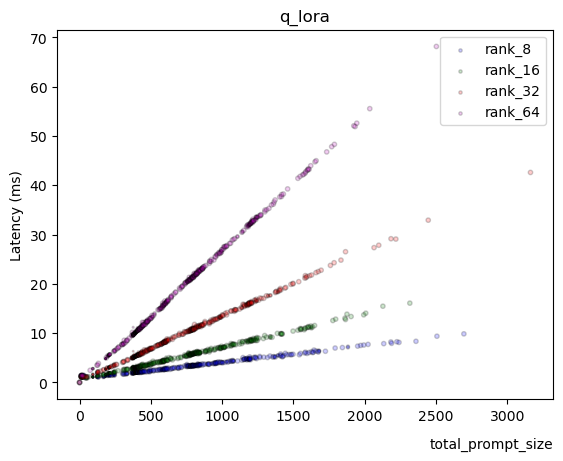

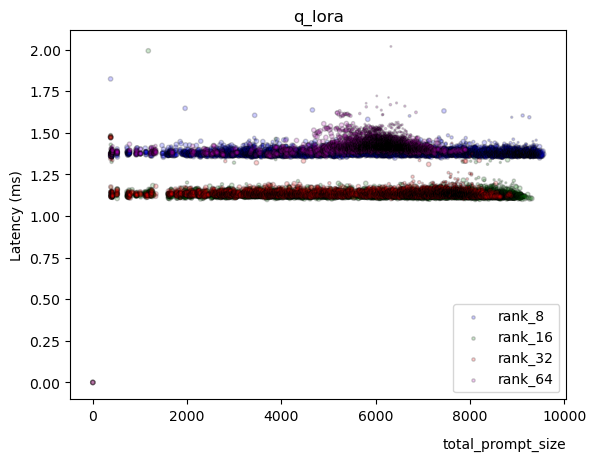

In [25]:
plot_tokenlen_rank_and_execution_time_relationship(prefill_steps_punica_rank_8, prefill_steps_punica_rank_16, prefill_steps_punica_rank_32, prefill_steps_punica_rank_64)
plot_tokenlen_rank_and_execution_time_relationship(decode_steps_punica_rank_8, decode_steps_punica_rank_16, decode_steps_punica_rank_32, decode_steps_punica_rank_64)

In [17]:
#_, prefill_steps_rank_8_only_tl, decode_steps_rank_8_only_tl = make_steps("rankTest/rank_8_only_tl.txt")
_, prefill_steps_triton_rank_16, decode_steps_triton_rank_16 = make_steps("rankTest/rank_16_only_tl.txt")
_, prefill_steps_triton_rank_32, decode_steps_triton_rank_32 = make_steps("rankTest/rank_32_only_tl.txt")
_, prefill_steps_triton_rank_64, decode_steps_triton_rank_64 = make_steps("rankTest/rank_64_only_tl.txt")

7449
Number of steps with no requests 
1
7442
Number of steps with no requests 
1
8345
Number of steps with no requests 
1


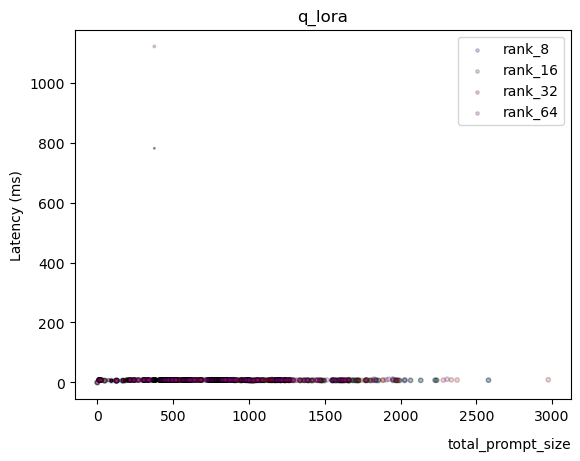

In [26]:
plot_tokenlen_rank_and_execution_time_relationship(prefill_steps_triton_rank_16, prefill_steps_triton_rank_16, prefill_steps_triton_rank_32, prefill_steps_triton_rank_64)

In [59]:
def plot_tokenlen_rank_8_16_ratio_and_execution_time_relationship_limited(title, step_list_rank_a, step_list_rank_2_1, step_list_rank_1_1, step_list_rank_1_2, step_list_rank_b):
    
    x1, y1 = create_xy(step_list_rank_a)
    tmp_x1 = [x for x in x1 if 1000 < x < 4000]
    y1 = [y for x, y in zip(x1, y1) if 1000 < x < 4000]
    x1 = tmp_x1
    #y1 = [0 if val > 1000 else val for val in y1]
    x1, y1, size1 = create_sub_plot_data_scatter(x1, y1)
    
    
    x2, y2 = create_xy(step_list_rank_2_1)
    tmp_x2 = [x for x in x2 if 1000 < x < 4000]
    y2 = [y for x, y in zip(x2, y2) if 1000 < x < 4000]
    x2 = tmp_x2
    #y2 = [0 if val > 1000 else val for val in y2]
    x2, y2, size2 = create_sub_plot_data_scatter(x2, y2)
    
    x3, y3 = create_xy(step_list_rank_1_1)
    tmp_x3 = [x for x in x3 if 1000 <x < 4000]
    y3 = [y for x, y in zip(x3, y3) if 1000 < x < 4000]
    x3 = tmp_x3
    #y3 = [0 if val > 1000 else val for val in y3]
    x3, y3, size3 = create_sub_plot_data_scatter(x3, y3)
    
    x4, y4 = create_xy(step_list_rank_1_2)
    tmp_x4 = [x for x in x4 if 1000 <x < 4000]
    y4 = [y for x, y in zip(x4, y4) if 1000 < x < 4000]
    x4 = tmp_x4
    #y4 = [0 if val > 1000 else val for val in y4]
    x4, y4, size4 = create_sub_plot_data_scatter(x4, y4)
    
    x5, y5 = create_xy(step_list_rank_b)
    tmp_x5 = [x for x in x5 if 1000 <x < 4000]
    y5 = [y for x, y in zip(x5, y5) if 1000 < x < 4000]
    x5 = tmp_x5
    #y4 = [0 if val > 1000 else val for val in y4]
    x5, y5, size5 = create_sub_plot_data_scatter(x5, y5)
    
    plt.scatter(x1, y1, s=size1, label="1:0", edgecolors='black', color='blue', alpha=0.2)
    plt.scatter(x2, y2, s=size2, label="2:1", edgecolors='black', color='red', alpha=0.4)
    plt.scatter(x3, y3, s=size3, label="1:1", edgecolors='black', color='green', alpha=0.4)
    plt.scatter(x4, y4, s=size4, label="1:2", edgecolors='black', color='m', alpha=0.4)
    plt.scatter(x5, y5, s=size5, label="0:1", edgecolors='black', color='yellow', alpha=0.2)
    
    plt.title(f"q_lora ({title})")
    plt.xlabel("total_prompt_size", labelpad=10, loc='right')
    plt.ylabel('Latency (ms)')
    plt.legend()
    plt.show()
    
def plot_tokenlen_rank_8_16_ratio_and_execution_time_relationship(title, step_list_rank_a, step_list_rank_2_1, step_list_rank_1_1, step_list_rank_1_2, step_list_rank_b):
    
    x1, y1 = create_xy(step_list_rank_a)
    tmp_x1 = [x for x in x1 if x < 4000]
    y1 = [y for x, y in zip(x1, y1) if x < 4000]
    x1 = tmp_x1
    #y1 = [0 if val > 1000 else val for val in y1]
    x1, y1, size1 = create_sub_plot_data_scatter(x1, y1)
    
    
    x2, y2 = create_xy(step_list_rank_2_1)
    tmp_x2 = [x for x in x2 if x < 4000]
    y2 = [y for x, y in zip(x2, y2) if  x < 4000]
    x2 = tmp_x2
    #y2 = [0 if val > 1000 else val for val in y2]
    x2, y2, size2 = create_sub_plot_data_scatter(x2, y2)
    
    x3, y3 = create_xy(step_list_rank_1_1)
    tmp_x3 = [x for x in x3 if x < 4000]
    y3 = [y for x, y in zip(x3, y3) if x < 4000]
    x3 = tmp_x3
    #y3 = [0 if val > 1000 else val for val in y3]
    x3, y3, size3 = create_sub_plot_data_scatter(x3, y3)
    
    x4, y4 = create_xy(step_list_rank_1_2)
    tmp_x4 = [x for x in x4 if x < 4000]
    y4 = [y for x, y in zip(x4, y4) if x < 4000]
    x4 = tmp_x4
    #y4 = [0 if val > 1000 else val for val in y4]
    x4, y4, size4 = create_sub_plot_data_scatter(x4, y4)
    
    x5, y5 = create_xy(step_list_rank_b)
    tmp_x5 = [x for x in x5 if x < 4000]
    y5 = [y for x, y in zip(x5, y5) if x < 4000]
    x5 = tmp_x5
    #y4 = [0 if val > 1000 else val for val in y4]
    x5, y5, size5 = create_sub_plot_data_scatter(x5, y5)
    
    plt.scatter(x1, y1, s=size1, label="1:0", edgecolors='black', color='blue', alpha=0.2)
    plt.scatter(x2, y2, s=size2, label="2:1", edgecolors='black', color='red', alpha=0.4)
    plt.scatter(x3, y3, s=size3, label="1:1", edgecolors='black', color='green', alpha=0.4)
    plt.scatter(x4, y4, s=size4, label="1:2", edgecolors='black', color='m', alpha=0.4)
    plt.scatter(x5, y5, s=size5, label="0:1", edgecolors='black', color='yellow', alpha=0.2)
    
    plt.title(f"q_lora ({title})")
    plt.xlabel("total_prompt_size", labelpad=10, loc='right')
    plt.ylabel('Latency (ms)')
    plt.legend()
    plt.show()

In [60]:
_, prefill_steps_rank_8_16_ratio_1, decode_steps_rank_8_16_ratio_1 = make_steps("rankTest/rank_8_16_ratio_1_only_custom.txt")
_, prefill_steps_rank_8_16_ratio_2, decode_steps_rank_8_16_ratio_2 = make_steps("rankTest/rank_8_16_ratio_2_only_custom.txt")
_, prefill_steps_rank_16_8_ratio_2, decode_steps_rank_16_8_ratio_2 = make_steps("rankTest/rank_16_8_ratio_2_only_custom.txt")

18785
Number of steps with no requests 
1
21755
Number of steps with no requests 
1
22030
Number of steps with no requests 
1


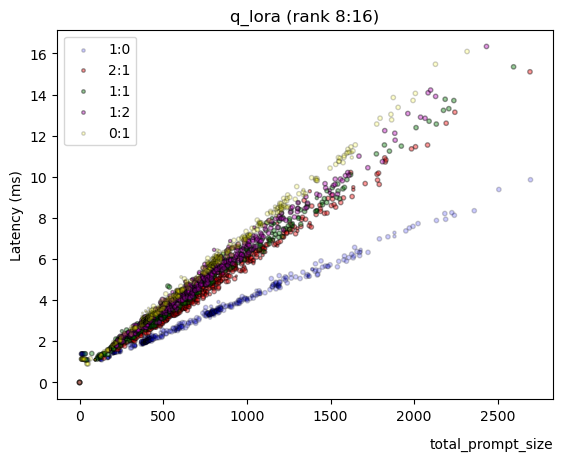

In [61]:
plot_tokenlen_rank_8_16_ratio_and_execution_time_relationship("rank 8:16", prefill_steps_rank_8, prefill_steps_rank_16_8_ratio_2, prefill_steps_rank_8_16_ratio_1, prefill_steps_rank_8_16_ratio_2, prefill_steps_rank_16)

In [62]:
_, prefill_steps_rank_8_64_ratio_1, decode_steps_rank_8_64_ratio_1 = make_steps("rankTest/rank_8_64_ratio_1_only_custom.txt")
_, prefill_steps_rank_8_64_ratio_2, decode_steps_rank_8_64_ratio_2 = make_steps("rankTest/rank_8_64_ratio_2_only_custom.txt")
_, prefill_steps_rank_64_8_ratio_2, decode_steps_rank_64_8_ratio_2 = make_steps("rankTest/rank_64_8_ratio_2_only_custom.txt")

23795
Number of steps with no requests 
2
27427
Number of steps with no requests 
1
25647
Number of steps with no requests 
1


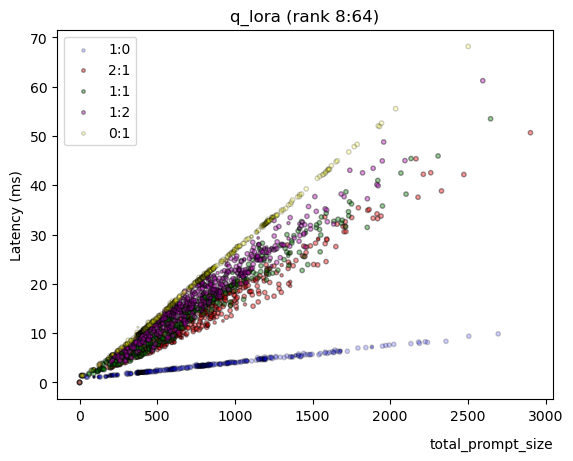

In [63]:
plot_tokenlen_rank_8_16_ratio_and_execution_time_relationship("rank 8:64", prefill_steps_rank_8, prefill_steps_rank_64_8_ratio_2, prefill_steps_rank_8_64_ratio_1, prefill_steps_rank_8_64_ratio_2, prefill_steps_rank_64)

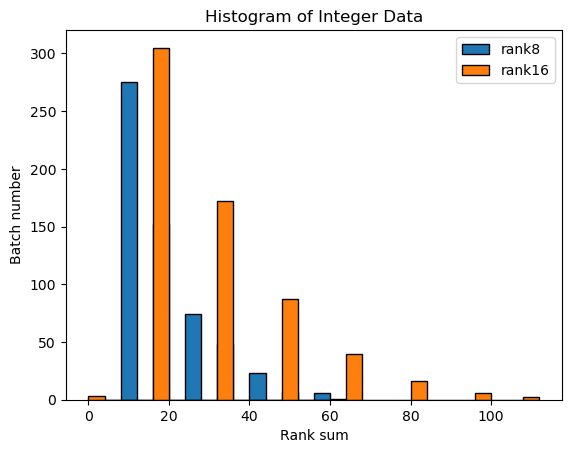

In [34]:
import matplotlib.pyplot as plt

# 정수로 이루어진 배열
data1 = [step["ranks"] for step in prefill_steps_rank_8]
data2 = [step["ranks"] for step in prefill_steps_rank_16]
data3 = [step["ranks"] for step in prefill_steps_rank_32]
data4 = [step["ranks"] for step in prefill_steps_rank_64]

# 히스토그램 그리기
plt.hist(data1, bins=range(min(data1), max(data1) + 2, 4), label="rank8", edgecolor='black')
#plt.xticks(range(min(data1), max(data1) + 2, 8))
plt.hist(data2, bins=range(min(data2), max(data2) + 2, 4), label="rank16", edgecolor='black')
#plt.xticks(range(min(data2), max(data2) + 2, 8))
# plt.hist(data3, bins=range(min(data3), max(data3) + 2, 4), label="rank32", edgecolor='black')
# plt.hist(data4, bins=range(min(data4), max(data4) + 2, 4), label="rank64", edgecolor='black')

# 그래프 꾸미기
plt.title('Histogram of Integer Data')
plt.xlabel('Rank sum')
plt.ylabel('Batch number')
plt.legend()

# 그래프 보여주기
plt.show()


In [64]:
def plot_rank_and_lora_relationship(step_list): 
    
    total_prompt_size_range = [0, 10000]
    step_list = [step for step in step_list if step["total_token_num"] >= total_prompt_size_range[0] and step["total_token_num"] <= total_prompt_size_range[1]]
    print(len(step_list))
    ranks = [step["ranks"] for step in step_list if step["request_num"] != 0]
    request_nums = [step["request_num"] for step in step_list if step["request_num"] != 0]
    #max_rank = [step["max_rank"] for step in step_list if step["request_num"] != 0]
    
    rannk_types_list = [step["rank_types"] for step in step_list if step["request_num"] != 0]
    
    low_rank_ratios = []
    for rank_types in rannk_types_list:
        low_rank_ratios.append(len([rank for rank in rank_types if rank == 16]) / len(rank_types))
            
    summarys = [step["summary"] for step in step_list if step["request_num"] != 0]
    summary_dict = aggregate_jsons(summarys)

    # x = [math.log2(a)/b for a,b in zip(ranks, request_nums)]
    
    x = low_rank_ratios

    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_start"]
    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_len"]
    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_loc"]
    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_bins"]
    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_scaling"]
    #x = max_rank
    y = summary_dict["get_qkv"]["detail"]["q_lora"]
    x_title = "ranks"
    y_title = "q_lora"
         
    correlation_matrix = np.corrcoef(x, y)
    correlation = correlation_matrix[0, 1]

    plt.scatter(x, y, s=10, edgecolors='black', color='blue', alpha=0.6)
    plt.title('rank - lora')
    plt.xlabel('average rank size')
    plt.ylabel('q lora Latency (ms)')
    plt.show()

In [46]:
_, prefill_steps_batch_size1, decode_steps_batch_size1 = make_steps("rankTest/1_300_token_request_per_batch.txt")
_, prefill_steps_total_token_1200, decode_steps_total_token_1200 = make_steps("rankTest/1200_token_request_per_batch_8_16_rank.txt")
_, prefill_steps_total_token_1200_tl, decode_steps_total_token_1200_tl = make_steps("rankTest/1200_token_request_per_batch.txt")

13290
Number of steps with no requests 
1
2842
Number of steps with no requests 
1
7379
Number of steps with no requests 
1


77


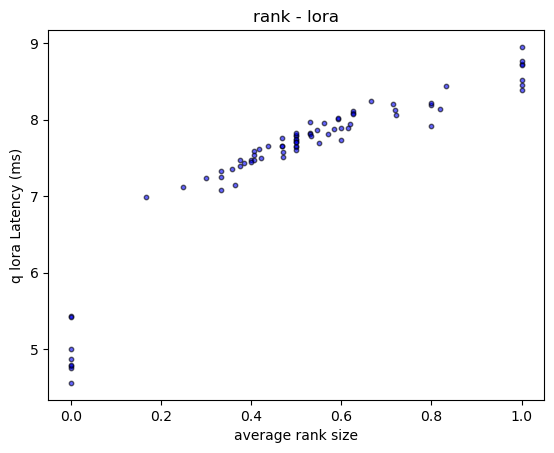

In [47]:
#plot_rank_and_lora_relationship(prefill_steps_batch_size1)
plot_rank_and_lora_relationship(prefill_steps_total_token_1200)

In [69]:
_, prefill_steps_total_token_1200_equal_rank_ratio, decode_steps_total_token_1200_equal_rank_ratio = make_steps("rankTest/1200_token_request_per_batch_equal_rank_ratio.txt")

36648
Number of steps with no requests 
1


In [4]:
def plot_rank_and_max_prompt_size_relationship(step_list): 
    ranks = [step["ranks"] for step in step_list if step["request_num"] != 0]
    request_nums = [step["request_num"] for step in step_list if step["request_num"] != 0]
    max_rank = [step["max_rank"] for step in step_list if step["request_num"] != 0]   
    rank_types_list = [step["rank_types"] for step in step_list if step["request_num"] != 0]
    max_lens_in_batch = [step["max_len_in_batch"] for step in step_list if step["request_num"] != 0]
            
    summarys = [step["summary"] for step in step_list if step["request_num"] != 0]
    summary_dict = aggregate_jsons(summarys)

    # x = [math.log2(a)/b for a,b in zip(ranks, request_nums)]
    
    x = max_lens_in_batch

    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_start"]
    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_len"]
    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_loc"]
    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_bins"]
    # x = summary_dict["get_qkv"]["detail"]["q_lora_adapter_scaling"]
    #x = max_rank
    y = summary_dict["get_qkv"]["detail"]["q_lora"]
    x_title = "ranks"
    y_title = "q_lora"
         
    correlation_matrix = np.corrcoef(x, y)
    correlation = correlation_matrix[0, 1]

    plt.scatter(x, y, s=10, edgecolors='black', color='blue', alpha=0.6)
    plt.title('rank - lora (rank8:rank64 = 2:1)')
    plt.xlabel('max prompt size in batch')
    plt.ylabel('q lora Latency (ms)')
    plt.show()

In [5]:
_, prefill_steps_total_token_1200_equal_rank_ratio_equal_batch_size, decode_steps_total_token_1200_equal_rank_ratio_equal_batch_size = make_steps("rankTest/1200_token_request_per_batch_equal_rank_ratio_equal_batch_size.txt")

11779
Number of steps with no requests 
1


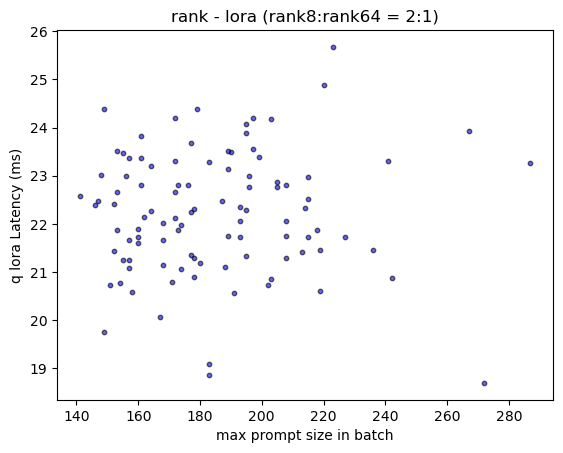

In [9]:
plot_rank_and_max_prompt_size_relationship(prefill_steps_total_token_1200_equal_rank_ratio_equal_batch_size)

## Latency of LoRA adapter

In [77]:
def read_until_batch_id(file_path, search_string="{\"batch_id\":", chunk_size=1024):
    buffer = ""
    next_string_distances = []
    current_position = 0  # 파일 내 현재 위치를 추적
    last_position = None
    file_length = 0
    
    with open(file_path, 'r', encoding='utf-8') as file:
        while True:
            chunk = file.read(chunk_size)
            if not chunk:
                break
                
            buffer += chunk
            file_length += len(chunk)

            while True:
                pos = buffer.find(search_string)
                if pos != -1:
                    # print(pos)
                    # print(current_position)
                    # print("=====")
                    
                    found_position = current_position + pos
                    # found_positions.append(found_position)

                    if last_position is None:
                        pass
                        #next_string_distances.append(found_position)
                    else:
                        next_string_distances.append(found_position - last_position)

                    last_position = found_position
                    
                    buffer = buffer[pos + len(search_string):]
                    
                    current_position += pos + len(search_string)
                else:
                    # current_position += len(buffer)
                    # buffer = buffer[max(0, len(buffer) - chunk_size):]
                            
                    if len(chunk) < chunk_size:
                        next_string_distances.append(file_length - current_position + len(search_string))
                        
                    break

    return next_string_distances


def make_steps(filename):
    search_string = "{\"batch_id\":"
    next_string_distances = read_until_batch_id(filename, search_string, 1024)
    
    step_time_data_list = []
    with open(filename, 'r', encoding='utf-8') as file:
        read_start_point = 0
        for i, idx in enumerate(next_string_distances):
            file.seek(read_start_point)
            data = file.read(idx - 2)
            json_data = json.loads(data)
            step_time_data_list.append(json_data)
            read_start_point = read_start_point + next_string_distances[i]

    for step in step_time_data_list:
        summary = initialize_dict_with_zeros(step_time_data_list[0]["layers"][0])
        step["summary"] = summary
        # print(i)
        for layer in step["layers"]:
            step["summary"] = add_dicts(step["summary"], layer)
            
    prefill_steps = [step for step in step_time_data_list if (step["arithType"]=="prefill" or step["arithType"]=="")]
    decode_steps = [step for step in step_time_data_list if (step["arithType"]=="decode" or step["arithType"]=="")]
    print(f"Number of steps with no requests ")
    print(len([step for step in step_time_data_list if step["arithType"]==""]))
    
    return step_time_data_list, prefill_steps, decode_steps

In [78]:
batchsize_1_token_1200_use_lora_true, batchsize_1_token_1200_use_lora_true_prefill, batchsize_1_token_1200_use_lora_true_decode = make_steps("log.txt")

Number of steps with no requests 
0


In [136]:
import matplotlib.pyplot as plt

def plot_latency_stack_graph(steps):
    categories = ['atten_norm', 'precache', 'get_qkv', 'postcache', 'atten_calc', 'get_o', 'total_ffn_time']
    get_qkv_keys = ['q_base', 'q_lora', 'q_rotary_emb', 'k_base', 'k_lora', 'k_rotary_emb', 'v_base', 'v_lora']
    get_o_keys = ['o_base', 'o_lora']

    fig, ax = plt.subplots(figsize=(10, 8))

    positions = range(len(categories))
    colors = plt.cm.tab20.colors
    num_steps = len(steps)
    bar_width = 0.7 / num_steps

    for idx, step in enumerate(steps):
        values = {
            'atten_norm': step["atten_norm"],
            'precache': step["precache"],
            'get_qkv': step["get_qkv"]["total_time"],
            'postcache': step["postcache"],
            'atten_calc': step["atten_calc"],
            'get_o': step["get_o"]["total_time"],
            'total_ffn_time': step["total_ffn_time"],
        }

        get_qkv_values = [
            step["get_qkv"]["detail"]["q_base"],
            step["get_qkv"]["detail"]["q_lora"],
            step["get_qkv"]["detail"]["q_rotary_emb"],
            step["get_qkv"]["detail"]["k_base"],
            step["get_qkv"]["detail"]["k_lora"],
            step["get_qkv"]["detail"]["k_rotary_emb"],
            step["get_qkv"]["detail"]["v_base"],
            step["get_qkv"]["detail"]["v_lora"]
        ]
        get_o_values = [
            step["get_o"]["detail"]["o_base"],
            step["get_o"]["detail"]["o_lora"]
        ]

        bottom_values = [0] * len(categories)
        offset = bar_width * (idx - num_steps / 2) + bar_width / 2

        # get_qkv bars
        for i, key in enumerate(get_qkv_keys):
            ax.bar([p + offset for p in positions], [get_qkv_values[i] if c == 'get_qkv' else 0 for c in categories], 
                   width=bar_width, bottom=bottom_values, color=colors[i % len(colors)], label=f'{key}' if idx == 0 else "", edgecolor='black')
            values["get_qkv"] -= get_qkv_values[i]
            bottom_values = [bottom_values[j] + (get_qkv_values[i] if c == 'get_qkv' else 0) for j, c in enumerate(categories)]

        # get_o bars
        for i, key in enumerate(get_o_keys):
            ax.bar([p + offset for p in positions], [get_o_values[i] if c == 'get_o' else 0 for c in categories], 
                   width=bar_width, bottom=bottom_values, color=colors[(i + len(get_qkv_keys)) % len(colors)], label=f'{key}' if idx == 0 else "", edgecolor='black')
            values["get_o"] -= get_o_values[i]
            bottom_values = [bottom_values[j] + (get_o_values[i] if c == 'get_o' else 0) for j, c in enumerate(categories)]

        # values bars
        main_bars = ax.bar([p + offset for p in positions], list(values.values()), width=bar_width, bottom=bottom_values, 
                           color='lightgray', label=f'Other' if idx == 0 else "", edgecolor='black')

        # 각 bar 위에 step 라벨 추가
        for bar in main_bars:
            yval = bar.get_height() + bar.get_y()
            ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{idx}', ha='center', va='bottom', fontsize=8, color='black')

    # 그래프 설정
    ax.set_xlabel('Categories')
    ax.set_ylabel('Time (ms)')
    ax.set_title('Stacked Bar Plot of Timing Data (Comparison)')
    ax.set_xticks(positions)  # x축 위치 설정
    ax.set_xticklabels(categories)  # x축 레이블 설정
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.xticks(rotation=45)
    plt.show()

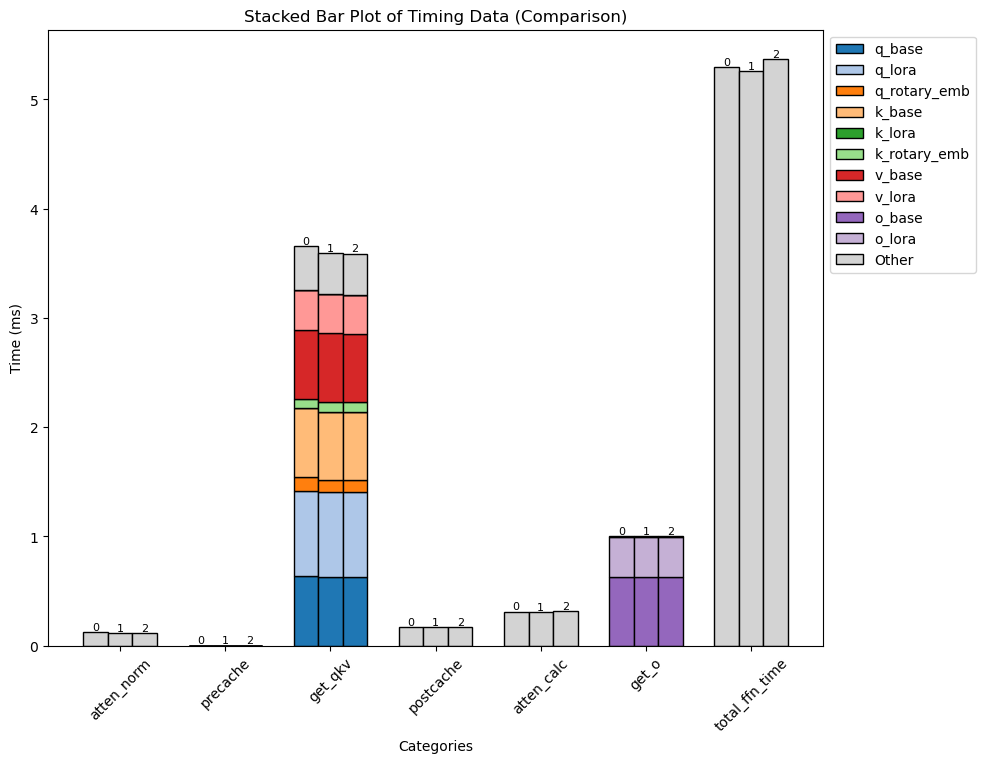

In [137]:
plot_latency_stack_graph(batchsize_1_token_1200_use_lora_true_prefill[0]["layers"][0:3])